In [1]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install scikit-learn-extra
!pip install coclust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=46e45e282ceeafb727b03e60205e70e400b5c4f1bc57d29556c9bf4b7344bff4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=06018ab0c1bd5b808152a9fd2756ace3b444346eb955826f46bd276d6058fbfd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Succe

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
def load_data():
    ng20 = fetch_20newsgroups(subset='test')
    corpus = ng20.data[:2000]
    labels = ng20.target[:2000]
    df_labels = pd.DataFrame(labels)
    df_labels.rename(columns = {0:'label'}, inplace = True)
    df_corpus = pd.DataFrame(corpus)
    df_corpus.rename(columns = {0:'text'}, inplace = True)
    return df_corpus, df_labels

In [4]:
df_corpus, df_labels = load_data()

# Pré-traitement des données textuelles

On enchaîne dans la fonction data_preprocessing les méthodes de nettoyage classiques.
* Suppression des tag HTML
* Conservation des mots uniquement
* Passage en minuscule
* Suppression des mots vides
* Tokenization
* Lemmatisation
* Réassemblage des articles

In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # définir les stop_words
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):

  # nettoyage des données
  article = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  article =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words

  # miniscule
  article = article.lower()

  # tokenization
  tokens = nltk.word_tokenize(article) # converts articles to tokens

  # stop_words removal
  article = [word for word in tokens if word not in stop_words] #removing stop words

  # lemmatization
  article = [lemmatizer.lemmatize(word) for word in article]

  # join words in preprocessed review
  article = ' '.join(article)

  return article

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# On applique le pré-traitement à nos données df_corpus
df_corpus['preprocessed_text'] = df_corpus['text'].apply(lambda article: data_preprocessing(article))
df_corpus

,text,preprocessed_text
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,v064mb9k ubvmsd cc buffalo edu neil b gandler ...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,rick miller rick ee uwm edu subject x face org...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mathew mathew mantis co uk subject strong weak...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,bakken c arizona edu dave bakken subject saudi...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,livesey solntze wpd sgi com jon livesey subjec...
...,...,...
1995,Organization: Queen's University at Kingston\n...,organization queen university kingston leek qu...
1996,From: stevek@cellar.org (Steve Kraisler)\nSubj...,stevek cellar org steve kraisler subject atf b...
1997,From: pmetzger@snark.shearson.com (Perry E. Me...,pmetzger snark shearson com perry e metzger su...
1998,From: d89-mad@ludd.luth.se (Mattias ]slund)\nS...,d89 mad ludd luth se mattias slund subject rem...


In [7]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [8]:
embeddings = model.encode(df_corpus['preprocessed_text'])

In [9]:
embeddings.shape

(2000, 384)

In [10]:
from sklearn.manifold import TSNE

In [15]:
def tSNE_method(data,n_components=3):
    # Initialize t-SNE object
    tsne = TSNE(n_components)
    df_tsne = pd.DataFrame(tsne.fit_transform(data))
    df_tsne['label'] = df_labels['label']
    df_tsne.columns = ['x', 'y','z', 'label']
    return df_tsne

In [18]:
df_tsne=tSNE_method(embeddings,n_components=3)

In [17]:
def plot_elbow(n_range, data):
    # Try different values of k
    k_values = range(1, n_range)
    inertia_values = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

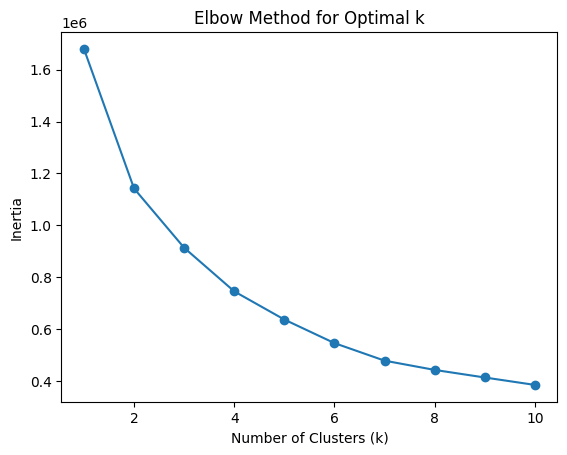

In [19]:
plot_elbow(11, df_tsne.iloc[:-1])

In [20]:
def plot_clusters(num_clusters):
    # Créer l'objet KMeans avec l'initialisation K-means++
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Initialize LabelEncoder object
    le = LabelEncoder()

    # Fit and transform the label column to numerical values
    df_tsne['label'] = le.fit_transform(df_tsne['label'])

    # Plot scatter plot
    plt.scatter(df_tsne['x'], df_tsne['y'],df_tsne['z'], c=df_tsne['label'], cmap='viridis')
    plt.colorbar()
    plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


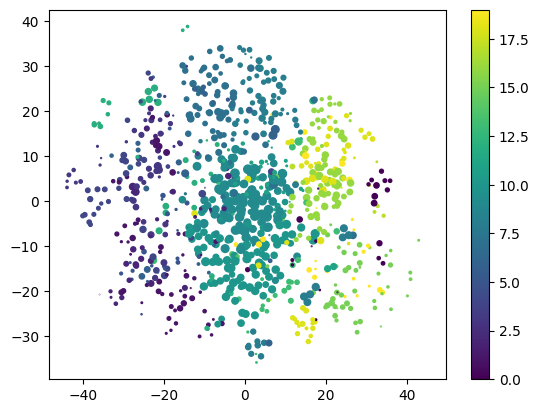

In [21]:
plot_clusters(4)

In [22]:
def kmeans_method(data, labels,  num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    kmeans.fit(data)
    kmeans_labels = kmeans.labels_
    nmi_kpp_pca = normalized_mutual_info_score(labels, kmeans_labels )
    ari_kpp_pca = adjusted_rand_score(labels, kmeans_labels)
    return nmi_kpp_pca, ari_kpp_pca

In [23]:
nmi_kpp_pca, ari_kpp_pca = kmeans_method(df_tsne.iloc[:,:-1], df_labels['label'],  4)
print("NMI pour kmeans++ avec la PCA:", nmi_kpp_pca)
print("ARI pour kmeans++ avec la PCA :", ari_kpp_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMI pour kmeans++ avec la PCA: 0.3230072277987352
ARI pour kmeans++ avec la PCA : 0.1323607407828581
